# Import and prepare Notebook Environement

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
sys.path.append(os.path.abspath("../../../src/"))

In [3]:
from EmbVector import Vector

## **Models**
## Getting datas
**best_sim mode** : The "Sum" colum of datas is the sum of vector Variation and all `top_number` vectors most similar to Variation without the vector of other existing variations for the gene

> **Formula**
>
> Sum = vect_Variation + sum(most_similar(`top_number`)) - sum(vect_other_variation_for_gene) 

In [4]:
def get_model(is_balanced):
    if is_balanced:
        path = "../../../datas/skipgram_A3316_WS20_E20_B10000_R2000_CTrue.model"
    else:
        path = "../../../datas/skipgram_3284.model"
    return path

In [5]:
datas = Vector(data_file = "../../../datas/training_clean", 
        model_path = get_model(is_balanced = True), 
        is_training = True)
# type_sum values : gene_var, best_sim, clean_art, sim_gene_var
# top_number only use with best_sim or sim_gene_var, defautl = 50
datas.get_vector_datas(is_notebook = True, type_sum =  "best_sim")

________________________Getting datas vectors_______________________
____________________________________________________________________
Number of genes/variations not foud : 688
____________________________________________________________________
Getting vectors finished in 59.73023474999354 seconds


In [6]:
datas_unbalanced = Vector(data_file = "../../../datas/training_clean", 
        model_path = get_model(is_balanced = False), 
        is_training = True)
# type_sum values : gene_var, best_sim, clean_art, sim_gene_var
# top_number only use with best_sim or sim_gene_var, defautl = 50
datas_unbalanced.get_vector_datas(is_notebook = True, type_sum =  "best_sim")

________________________Getting datas vectors_______________________
____________________________________________________________________
Number of genes/variations not foud : 841
____________________________________________________________________
Getting vectors finished in 57.517635150004935 seconds


## Split the datas
Spliting the datas from the first model (without new articles) by 80% for training, and 20% fort test

In [7]:
X = datas.vectors[['Gene','Variation','Sum']]
Y = pd.get_dummies(datas.vectors["Class"]).values

#X = datas_unbalanced.vectors[['Gene','Variation','Sum']]
#Y = pd.get_dummies(datas_unbalanced.vectors["Class"]).values

In [8]:
print(X['Gene'].shape)
print(X['Variation'].shape)
print(X['Sum'].shape)

(3314,)
(3314,)
(3314,)


## Models : datas concatenated
First we need to split datas to reshape  and clean the shape

In [9]:
X_gene = X["Gene"]
X_var = X["Variation"]
X_sum = X["Sum"]

In [10]:
X_gene = X_gene.values.reshape(X_gene.shape[0], 1)
X_var = X_var.values.reshape(X_var.shape[0], 1)
X_sum = X_sum.values.reshape(X_sum.shape[0], 1)

In [11]:
def convert_to_np_gene(Object):
    np_list = []
    for obj in Object:
        cop = obj[0].copy()
        np_list.append(np.array(cop))
    return np.array(np_list)

def convert_to_np_var_sum(Object):
    np_list = []
    for obj in Object:
        for o in obj:
            cop = o[0].copy()
            np_list.append(np.array(cop))
    return np.array(np_list)

In [12]:
X_gene = convert_to_np_gene(X_gene)
X_var = convert_to_np_var_sum(X_var)
X_sum = convert_to_np_var_sum(X_sum)

In [13]:
print("X_gene : " + str(X_gene.shape))
print("X_var : " + str(X_var.shape))
print("X_sum : " + str(X_sum.shape))

print("Y : " + str(Y.shape))

X_gene : (3314, 100)
X_var : (3314, 100)
X_sum : (3314, 100)
Y : (3314, 9)


## Reform the X_train with cleaned shape

In [14]:
X_concat = np.concatenate((X_gene, X_var, X_sum), axis = 1) 

In [15]:
X_concat.shape

(3314, 300)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_concat, Y, test_size = 0.2, random_state = 42, stratify=Y)
print("X_train : " + str(X_train.shape))
print("Y_train : " + str(Y_train.shape))
print("X_test : " + str(X_test.shape))
print("Y_test : " + str(Y_test.shape))

X_train : (2651, 300)
Y_train : (2651, 9)
X_test : (663, 300)
Y_test : (663, 9)


## Over Sampling

In [17]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_train, Y_train = oversample.fit_resample(X_train, Y_train)
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

print(X_train.shape)
print(Y_train.shape)

(4128, 300)
(4128, 9)


In [18]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(4128, 300, 1)
(663, 300, 1)


## **Building short model with Gene, Variation and Sum datas**

## Model 1 : One layer - softmax

In [19]:
def create_sm_simple():
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Flatten())
    model.add(layers.Dense(9, activation='softmax'))

    return model

2021-10-26 18:47:22.166917: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-26 18:47:22.167147: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-26 18:47:22.167258: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


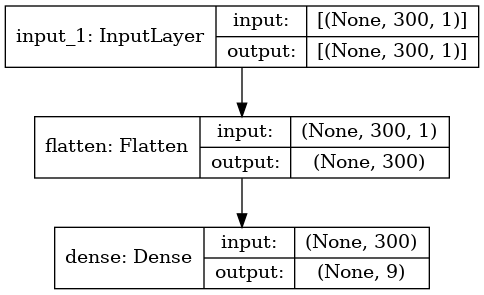

In [20]:
model_sm = create_sm_simple()
model_sm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_sm, "SM_W2V_bs.png", show_shapes= True)

## Model 2 : Two layers - Dense Softmax

In [21]:
def create_dsm_simple():
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dense(9, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(9, activation='softmax'))

    return model

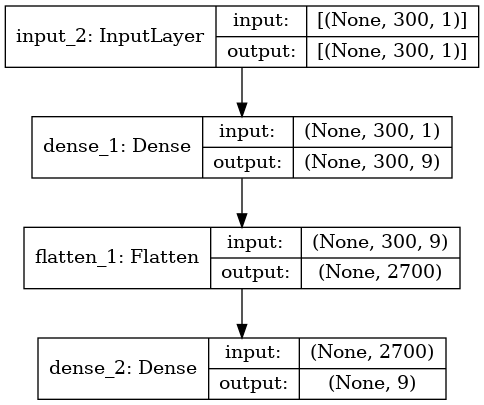

In [22]:
model_dsm = create_dsm_simple()
model_dsm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_dsm, "DSM_W2V_bs.png", show_shapes= True)

## **Building CNN model with Gene, Variation and Sum datas**

## Model 1 : Simple

In [23]:
def create_model_simple():
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Conv1D(32, kernel_size=(3), activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(9, activation='softmax'))

    return model

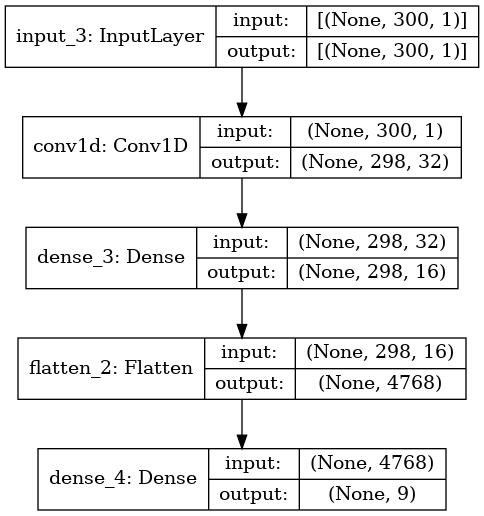

In [24]:
model_simple = create_model_simple()
model_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_simple, "CNN_W2V_bs.png", show_shapes= True)

## Model 2 : Complex

In [25]:
def create_model_complex():
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Conv1D(64, kernel_size=(3), activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(9, activation='softmax'))
    
    return model

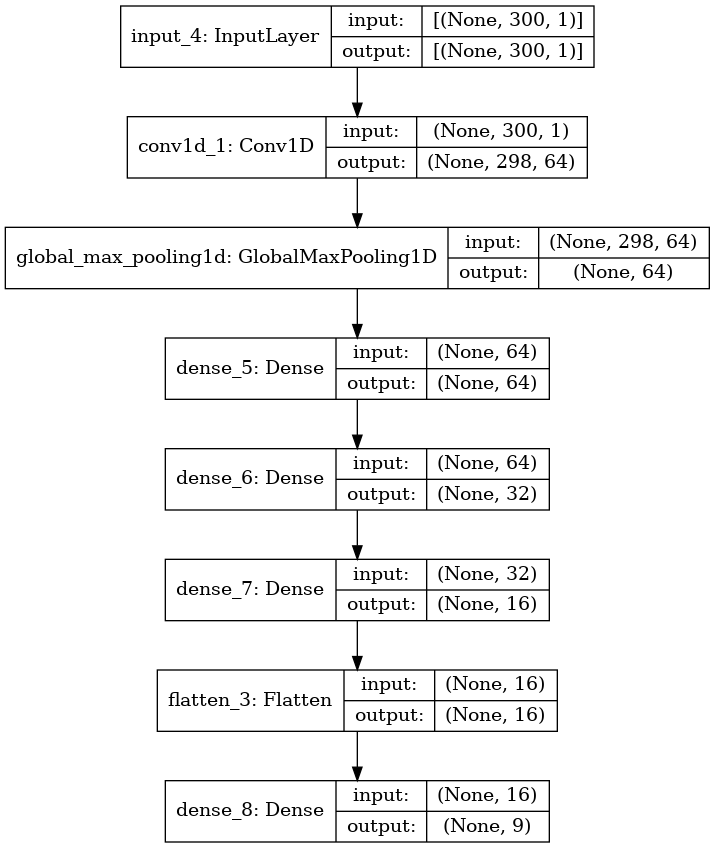

In [26]:
model_complex = create_model_complex()
model_complex.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_complex, "CNN_W2V_Complex_bs.png", show_shapes= True)

## **Training**

## Short Model 1 : Softmax

In [27]:
history_sm = model_sm.fit(X_train, Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

2021-10-26 18:47:23.190192: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-26 18:47:23.190785: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2803205000 Hz


In [28]:
loss, accuracy = model_sm.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 53.004 %


In [29]:
loss, accuracy = model_sm.evaluate(X_test, Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  50.980 %


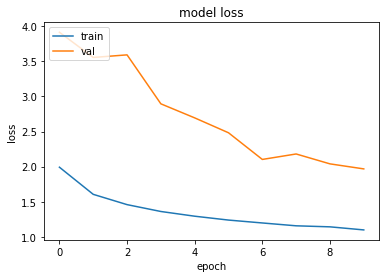

In [30]:
# summarize history for loss
plt.plot(history_sm.history['loss'])
plt.plot(history_sm.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## Short Model 2 : Dense - Softmax

In [31]:
history_dsm = model_dsm.fit(X_train, Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

In [32]:
loss, accuracy = model_dsm.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 66.134 %


In [33]:
loss, accuracy = model_dsm.evaluate(X_test, Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  53.997 %


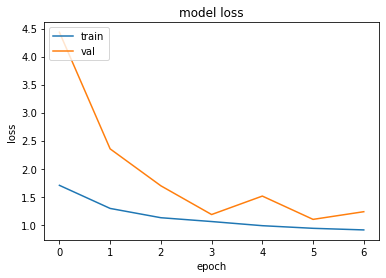

In [34]:
# summarize history for loss
plt.plot(history_dsm.history['loss'])
plt.plot(history_dsm.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## CNN Model 1 : Simple

In [35]:
history_simple = model_simple.fit(X_train, Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

In [36]:
loss, accuracy = model_simple.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 81.371 %


In [37]:
loss, accuracy = model_simple.evaluate(X_test, Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  57.919 %


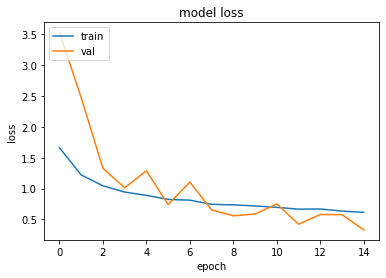

In [38]:
# summarize history for loss
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## CNN Model 2 : Complex

In [39]:
history_complex = model_complex.fit(X_train, Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

In [40]:
loss, accuracy = model_complex.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 23.062 %


In [41]:
loss, accuracy = model_complex.evaluate(X_test, Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  28.356 %


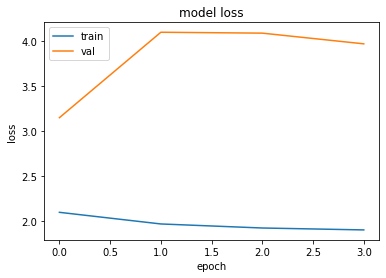

In [42]:
# summarize history for loss
plt.plot(history_complex.history['loss'])
plt.plot(history_complex.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## **Saving models**

In [43]:
model_sm.save("../../../results/Models/skipgram_over_sampling/skipgram_os_sm_Concat_bs.model")

2021-10-26 18:47:49.777641: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../../results/Models/skipgram_over_sampling/skipgram_os_sm_Concat_bs.model/assets


In [44]:
model_dsm.save("../../../results/Models/skipgram_over_sampling/skipgram_os_dsm_Concat_bs.model")

INFO:tensorflow:Assets written to: ../../../results/Models/skipgram_over_sampling/skipgram_os_dsm_Concat_bs.model/assets


In [45]:
model_simple.save("../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_simple_Concat_bs.model")

INFO:tensorflow:Assets written to: ../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_simple_Concat_bs.model/assets


In [46]:
model_complex.save("../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_complex_Concat_bs.model")

INFO:tensorflow:Assets written to: ../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_complex_Concat_bs.model/assets


__________________________________

# Clear the Session and delete model

In [47]:
keras.backend.clear_session()
del model_sm
del model_dsm
del model_simple
del model_complex

__________________________________

__________________________________

# **Confusion matrix**

In [48]:
def plot_matrices(model, x_test, y_test):
  probas = model.predict(x_test)
  pred_indices = np.argmax(probas, axis=1)
  classes = np.array(range(1, 10))
  preds = classes[pred_indices]
  print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
  print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds))) 

  confusion  = confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)
  precision =(confusion/confusion.sum(axis=0))
  recall =(((confusion.T)/(confusion.sum(axis=1))).T)
  f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.08]},figsize=(22,6)) 
  labels = [1,2,3,4,5,6,7,8,9]

  # Confusion matrix 
  g1 = sns.heatmap(confusion,cbar=False,ax=ax1,annot=True, cmap="Blues", fmt=".3f", xticklabels=labels, yticklabels=labels,)
  g1.set_ylabel('Original Class')
  g1.set_xlabel('Predicted Class')
  g1.set_title('Confusion') 

  # Precision matrix 
  g2 = sns.heatmap(precision,cmap="Blues",cbar=False,ax=ax2, annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
  g2.set_ylabel('Original Class')
  g2.set_xlabel('Predicted Class')
  g2.set_yticks(labels)
  g2.set_title('Precision') 

  # Recall matrix 
  g3 = sns.heatmap(recall,cmap="Blues",ax=ax3, cbar_ax=axcb, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
  g3.set_ylabel('Original Class')
  g3.set_xlabel('Predicted Class')
  g3.set_title('Recall')
  g3.set_yticks(labels) 

  for ax in [g1,g2,g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=0)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
  
  plt.show()


In [49]:
model_sm = keras.models.load_model("../../../results/Models/skipgram_over_sampling/skipgram_os_sm_Concat_bs.model")
model_dsm = keras.models.load_model("../../../results/Models/skipgram_over_sampling/skipgram_os_dsm_Concat_bs.model")

model_simple = keras.models.load_model("../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_simple_Concat_bs.model")
model_complex = keras.models.load_model("../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_complex_Concat_bs.model")

Log loss: 1.3916747196539563
Accuracy: 0.5098039215686274


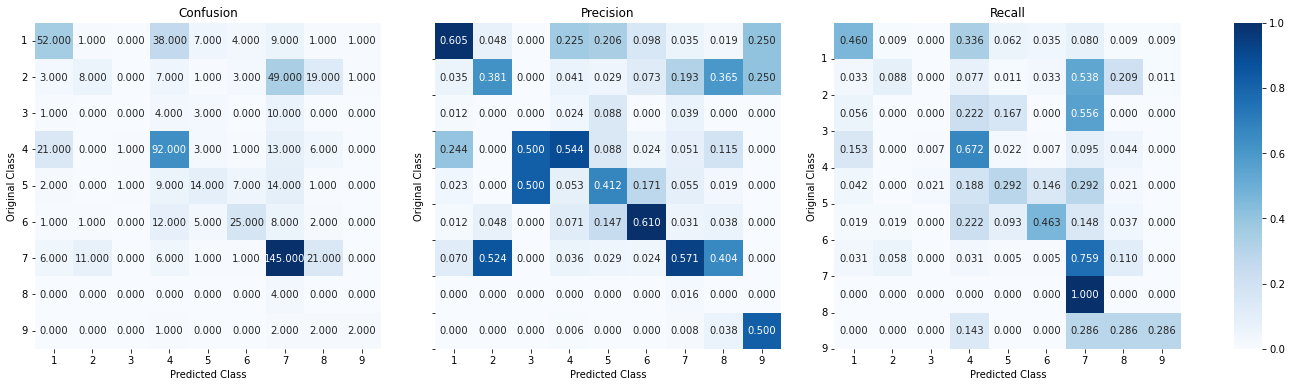

In [50]:
plot_matrices(model_sm, X_test, Y_test)

Log loss: 1.3268336262104423
Accuracy: 0.5399698340874811


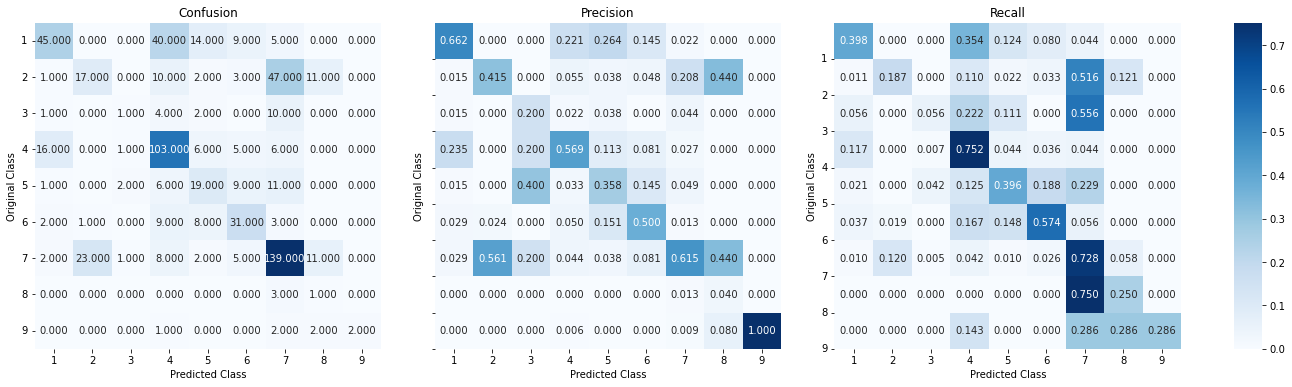

In [51]:
plot_matrices(model_dsm, X_test, Y_test)

Log loss: 1.2526470089901405
Accuracy: 0.579185520361991


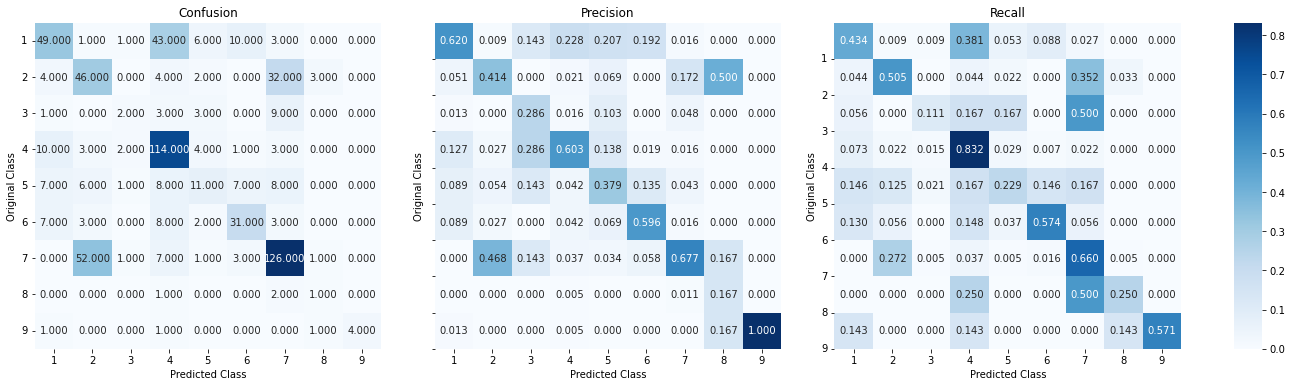

In [52]:
plot_matrices(model_simple, X_test, Y_test)

Log loss: 1.9896806933401576
Accuracy: 0.28355957767722473


/tmp/ipykernel_277967/3591071593.py:10: RuntimeWarning: invalid value encountered in true_divide
  precision =(confusion/confusion.sum(axis=0))


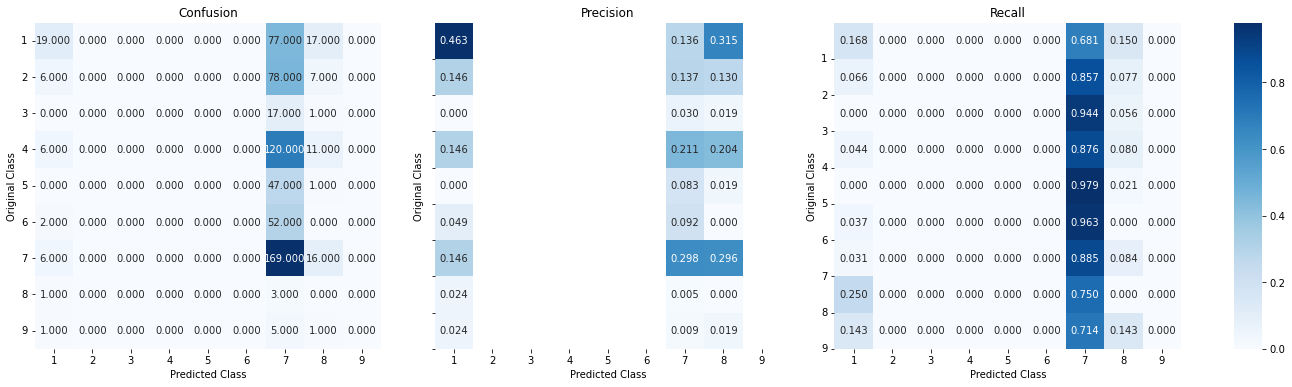

In [53]:
plot_matrices(model_complex, X_test, Y_test)